# Packages loading and general environment setting

In [1]:
# We set the path of the (so nicely nice) gaiaunlimited stuff BEFORE importing gaiaunlimited stuff
import os
os.environ['GAIAUNLIMITED_DATADIR'] = '/home/rafaelbertolotto/gaiaunlimited_files'

In [2]:
# We import the rest of the cool stuff
import numpy as np
import pandas as pd
import warnings
from scipy import interpolate
from astropy import coordinates
from astropy.coordinates import Galactic
import astropy.units as u
import mass_photometry_tools as massPhoto
from astropy.coordinates import LSR
from astropy.coordinates import SkyCoord
from zero_point import zpt
from gaiaunlimited.selectionfunctions import DR3RVSSelectionFunction
from gaiaunlimited.selectionfunctions import DR3SelectionFunctionTCG_hpx7
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Warnings are anoying... we do not like warnings...
warnings.filterwarnings("ignore")
sns.set_context("talk")
mpl.style.use("seaborn")
sns.set_context("paper",font_scale=1.5)
sns.set_style("whitegrid")

# Isochrone building:

In [3]:
# ages isochrones generation (SP locus generation is based on 100Myr isochrone, which is for ages[0]):
BR_to_MG_interps          = []
MG_to_BR_interps          = []
ages = np.arange(1e7,11e7,1e7).tolist()
for i in np.arange(0,len(ages),1):
    age                              = ages[i]
    BR_to_MG_interp, MG_to_BR_interp = massPhoto.iso_interpolation_generator(age)
    BR_to_MG_interps                 = BR_to_MG_interps+[BR_to_MG_interp]
    MG_to_BR_interps                 = MG_to_BR_interps+[MG_to_BR_interp]
    
MS_BR_to_MG_interp                   = BR_to_MG_interps[ages.index(100e6)]
MS_MG_to_BR_interp                   = MG_to_BR_interps[ages.index(100e6)]
BR_interval                      = np.arange(MS_BR_to_MG_interp.x.min(),MS_BR_to_MG_interp.x.max()-0.001,0.001)

MS_isochrone = pd.DataFrame({'BR':BR_interval,'MG':MS_BR_to_MG_interp(BR_interval)})

# Gaia DR3 and GOG data loading

In [4]:
gdr3 = pd.read_csv("input_cat/gaiaDR3_200pc.csv",usecols=['source_id',
                                                          'ra',
                                                          'ra_error',
                                                          'dec',
                                                          'dec_error',
                                                          'parallax',
                                                          'parallax_error',
                                                          'pmra',
                                                          'pmra_error',
                                                          'pmdec',
                                                          'pmdec_error',
                                                          'radial_velocity',
                                                          'radial_velocity_error',
                                                          'phot_g_mean_mag',
                                                          'phot_bp_mean_mag',
                                                          'phot_rp_mean_mag',
                                                          'phot_g_mean_flux_error',
                                                          'phot_g_mean_flux',
                                                          'phot_bp_mean_flux_error',
                                                          'phot_bp_mean_flux',
                                                          'phot_rp_mean_flux_error',
                                                          'phot_rp_mean_flux',
                                                          'nu_eff_used_in_astrometry',
                                                          'pseudocolour', 
                                                          'ecl_lat', 
                                                          'astrometric_params_solved',
                                                          'grvs_mag',
                                                          'rv_template_teff',
                                                          'ruwe',
                                                          'phot_bp_rp_excess_factor'])

gog = pd.read_csv("input_cat/GOG_DR3_200pc.csv",usecols=['source_id',
                                                         'ra',
                                                         'dec',
                                                         'parallax',
                                                         'parallax_error',
                                                         'pmra',
                                                         'pmdec',
                                                         'radial_velocity',
                                                         'radial_velocity_error',
                                                         'phot_g_mean_mag',
                                                         'phot_bp_mean_mag',
                                                         'phot_rp_mean_mag',
                                                         'phot_g_mean_flux_error',
                                                         'phot_g_mean_flux'])

# Common cleaning for GOG and Gaia data

In [5]:
gdr3 = gdr3[gdr3.phot_g_mean_mag <= 18.5]
gog  = gog[gog.phot_g_mean_mag <= 18.5]
# gdr3.phot_g_mean_mag,gdr3.phot_g_mean_flux = correct_gband(gdr3.phot_bp_mean_mag-gdr3.phot_rp_mean_mag, 
#                                                             gdr3.astrometric_params_solved, 
#                                                             gdr3.phot_g_mean_mag, 
#                                                             gdr3.phot_g_mean_flux )

# Cleanning and calculations for Gaia DR3 data

## General corrections

In [6]:
# General corrections:
# Zero point parallax correction
zpt.load_tables()
zeropoint     = zpt.get_zpt(gdr3.phot_g_mean_mag,gdr3.nu_eff_used_in_astrometry,
                            gdr3.pseudocolour, gdr3.ecl_lat, gdr3.astrometric_params_solved)
gdr3.parallax = gdr3.parallax+zeropoint

# Radial velocity correction
rv_to_correct_class                             = (gdr3.grvs_mag >= 6) & (gdr3.grvs_mag <= 12) & (gdr3.rv_template_teff >= 8500) & (gdr3.rv_template_teff <= 14500)
gdr3.loc[rv_to_correct_class,'radial_velocity'] = gdr3[rv_to_correct_class].radial_velocity-7.98*gdr3[rv_to_correct_class].grvs_mag

## General photometric and kinematic calculations

In [7]:
# Absolute magnitude and color calculation:
MG              = gdr3["phot_g_mean_mag"]+5-5*np.log10(1000/gdr3["parallax"])
BR              = gdr3["phot_bp_mean_mag"]-gdr3["phot_rp_mean_mag"]

# Photometric errors calculation:
dF        = gdr3["phot_g_mean_flux_error"]
F         = gdr3["phot_g_mean_flux"]
varpi     = gdr3["parallax"]
dvarpi    = gdr3["parallax_error"]
G         = gdr3["phot_g_mean_mag"]

# Zero points phtometric uncertainties comes from https://cdsarc.cds.unistra.fr/viz-bin/ReadMe/I/350?format=html&tex=true:
sigmaG0   = 0.0027553202
sigmaGBP0 = 0.0027901700
sigmaGRP0 = 0.0037793818

MG_F_err     = np.sqrt((2.5*dF/(np.log(10)*F))**2+sigmaG0**2)
varpi_err    = 5*dvarpi/(np.log(10)*varpi)
MG_err       = np.sqrt(MG_F_err**2+varpi_err**2)

dF           = gdr3["phot_bp_mean_flux_error"]
F            = gdr3["phot_bp_mean_flux"]
BP_err       = np.sqrt((2.5*dF/(np.log(10)*F))**2+sigmaGBP0**2)

dF           = gdr3["phot_rp_mean_flux_error"]
F            = gdr3["phot_rp_mean_flux"]
RP_err       = np.sqrt((2.5*dF/(np.log(10)*F))**2+sigmaGRP0**2)

BR_err       = np.sqrt(BP_err**2+RP_err**2)

# We join the new photometric info to the rest of the data:
photo           = pd.concat([MG,BR,MG_err,MG_F_err,BP_err,RP_err,BR_err],axis=1)
photo.columns   = ["MG","BR","MG_err","G_err","BP_err","RP_err","BR_err"]
gdr3            = pd.concat([gdr3,photo],axis=1)

# galactic cartesian positions and velocities calculation:
newcolNames     = ["error_over_parallax","error_over_radial_velocity","X","Y","Z","U","V","W"]
newcols         = pd.DataFrame(np.zeros(shape=(gdr3.shape[0],len(newcolNames))),columns=newcolNames)

gdr3            = gdr3.reset_index(drop=True)
newcols         = newcols.reset_index(drop=True)
gdr3            = pd.concat([gdr3,newcols],axis=1)

icrs            = coordinates.ICRS(ra              = gdr3["ra"].to_numpy()*u.degree,
                                   dec             = gdr3["dec"].to_numpy()*u.degree,
                                   distance        = (1000/gdr3["parallax"]).to_numpy()*u.pc,
                                   pm_ra_cosdec    = gdr3["pmra"].to_numpy()*u.mas/u.yr,
                                   pm_dec          = gdr3["pmdec"].to_numpy()*u.mas/u.yr,
                                   radial_velocity = gdr3["radial_velocity"].to_numpy()*u.km/u.s)

# We transform from ICRS to Galactic
XYZUVW                             = icrs.transform_to(Galactic()) 
gdr3["X"]                          = pd.DataFrame(XYZUVW.cartesian.x)
gdr3["Y"]                          = pd.DataFrame(XYZUVW.cartesian.y)
gdr3["Z"]                          = pd.DataFrame(XYZUVW.cartesian.z)
gdr3["U"]                          = pd.DataFrame(XYZUVW.velocity.d_x)
gdr3["V"]                          = pd.DataFrame(XYZUVW.velocity.d_y)
gdr3["W"]                          = pd.DataFrame(XYZUVW.velocity.d_z)
gdr3["error_over_parallax"]        = gdr3.parallax_error/gdr3.parallax
gdr3["error_over_radial_velocity"] = gdr3.radial_velocity_error/gdr3.radial_velocity

# We compute the LSR proper motions, to do so, we set all RVs NaNs to 0
icrs            = coordinates.ICRS(ra              = gdr3["ra"].to_numpy()*u.degree,
                                   dec             = gdr3["dec"].to_numpy()*u.degree,
                                   distance        = (1000/gdr3["parallax"]).to_numpy()*u.pc,
                                   pm_ra_cosdec    = gdr3["pmra"].to_numpy()*u.mas/u.yr,
                                   pm_dec          = gdr3["pmdec"].to_numpy()*u.mas/u.yr,
                                   radial_velocity = gdr3["radial_velocity"].fillna(0).to_numpy()*u.km/u.s)

# We transform from ICRS to LSR
lsr             = icrs.transform_to(LSR())
gdr3['pmraLSR']                    = pd.DataFrame(lsr.pm_ra_cosdec)
gdr3['pmdecLSR']                   = pd.DataFrame(lsr.pm_dec)

# Kinematic error calculation

## Cartesian galactic position errors
To propagate errors from $(\alpha,\delta,\varpi,\mu_{\alpha},\mu_{\delta},v_r)$ to $(X,Y,Z,U,V,W)_G$ (where the index G accounts for the Galactic coordinate system), we first need to propagate erros from $(\alpha,\delta,\varpi,\mu_{\alpha},\mu_{\delta},v_r)$ to $(X,Y,Z,U,V,W)_I$ (where the index I accounts for the ICRS coordinate system). To do so, we must consider the position and velocity in this system:

$\vec{r}_I=\frac{A_p}{\varpi}\left[cos(\alpha)cos(\delta)\hat{x}+sin(\alpha)cos(\delta)\hat{y}+sin(\delta)\hat{z}\right]$

$\vec{v}_I=\left[v_rcos(\alpha)cos(\delta)-\frac{A_v}{\varpi}(\mu_{\alpha}^*sin(\alpha)+\mu_{\delta}sin(\delta)cos(\alpha))\right]\hat{x}+\left[v_rsin(\alpha)cos(\delta)-\frac{A_v}{\varpi}(\mu_{\alpha}^*cos(\alpha)+\mu_{\delta}sin(\delta)sin(\alpha))\right]\hat{y}+\left[v_rsin(\delta)+\frac{A_v}{\varpi}\mu_{\delta}cos(\delta)\right]\hat{z}$

Where $\mu_{\alpha}=\mu_{\alpha}cos(\delta)$. We then propagate errors and easily find that:

$\Delta X_I=|X_I|\sqrt{\left(\frac{\Delta\varpi}{\varpi}\right)^2+(tan(\alpha)\Delta\alpha)^2+(tan(\delta)\Delta\delta)^2}$

$\Delta Y_I=|Y_I|\sqrt{\left(\frac{\Delta\varpi}{\varpi}\right)^2+\left(\frac{\Delta\alpha}{tan(\alpha)}\right)^2+(tan(\delta)\Delta\delta)^2}$

$\Delta Z_I=|Z_I|\sqrt{\left(\frac{\Delta\varpi}{\varpi}\right)^2+\left(\frac{\Delta\delta}{tan(\delta)}\right)^2}$

Note that by substituying $\alpha$ by $l$ and $\delta$ by $b$ we get the cartesian Galactic position in terms of the spherical Galactic positions. Once we propagate the errors to the cartesian equatorial positions, we can easily propagate these errors to the Galactic cartesian positions by a simple rotation, indeed, since $\vec{r}_G=A_G\vec{r}_I$ where $A_G$ is the rotation matrix from ICRS to Galactic system. Then, if $A_G=a_{ij}$, we can easily obtain the errors in position by operating as follow:

$\Delta X_G= \sqrt{(a_{11}\Delta X_I)^2+(a_{12}\Delta Y_I)^2+(a_{13}\Delta Z_I)^2}$

$\Delta Y_G= \sqrt{(a_{21}\Delta X_I)^2+(a_{22}\Delta Y_I)^2+(a_{23}\Delta Z_I)^2}$

$\Delta Z_G= \sqrt{(a_{31}\Delta X_I)^2+(a_{32}\Delta Y_I)^2+(a_{33}\Delta Z_I)^2}$

In [8]:
# Rotation matrix from ICRS to Galactic
icrs_to_gal = np.matrix('-0.0548755604162154 -0.8734370902348850 -0.4838350155487132;\
                         0.4941094278755837 -0.4448296299600112 0.7469822444972189;\
                        -0.8676661490190047 -0.1980763734312015 0.4559837761750669')

# Constant to go from mas/yr to km/s
Av       = 4.74047
masToRad = 4.8481368E-9

# We define the matrix for the error calculations
icrs_errors = pd.DataFrame(columns=['X_error','Y_error','Z_error'])
gala_errors = pd.DataFrame(columns=['X_error','Y_error','Z_error','U_error','V_error','W_error','pml_error','pmb_error'])

# This dataframe contains the propper motion 3-dimensional cartesian vector
pm = pd.DataFrame(columns=['pm1','pm2','pm3'])

# We calculate ICRS cartesian errors
icrs_errors.X_error = icrs.cartesian.x
icrs_errors.Y_error = icrs.cartesian.y
icrs_errors.Z_error = icrs.cartesian.z

icrs_errors.X_error = np.abs(icrs_errors.X_error)*np.sqrt((gdr3.parallax_error/gdr3.parallax)**2+\
                                                          (np.tan(gdr3.ra*np.pi/180)*gdr3.ra_error*masToRad)**2+\
                                                          (np.tan(gdr3.dec*np.pi/180)*gdr3.dec_error*masToRad)**2)

icrs_errors.Y_error = np.abs(icrs_errors.Y_error)*np.sqrt((gdr3.parallax_error/gdr3.parallax)**2+\
                                                          (gdr3.ra_error*masToRad/np.tan(gdr3.ra*np.pi/180))**2+\
                                                          (np.tan(gdr3.dec*np.pi/180)*gdr3.dec_error*masToRad)**2)

icrs_errors.Z_error = np.abs(icrs_errors.Z_error)*np.sqrt((gdr3.parallax_error/gdr3.parallax)**2+\
                                                          (gdr3.dec_error*masToRad/np.tan(gdr3.dec*np.pi/180))**2)

# We propagate cartesian errors from ICRS to Galactic through the rotation matrix
gala_errors.X_error = np.sqrt((icrs_to_gal[0,0]*icrs_errors.X_error)**2+\
                              (icrs_to_gal[0,1]*icrs_errors.Y_error)**2+\
                              (icrs_to_gal[0,2]*icrs_errors.Z_error)**2)

gala_errors.Y_error = np.sqrt((icrs_to_gal[1,0]*icrs_errors.X_error)**2+\
                              (icrs_to_gal[1,1]*icrs_errors.Y_error)**2+\
                              (icrs_to_gal[1,2]*icrs_errors.Z_error)**2)

gala_errors.Z_error = np.sqrt((icrs_to_gal[2,0]*icrs_errors.X_error)**2+\
                              (icrs_to_gal[2,1]*icrs_errors.Y_error)**2+\
                              (icrs_to_gal[2,2]*icrs_errors.Z_error)**2)

## Galactic proper motion errors
Now, to calculate the velocity errors, we first need to consider the cartesian vector of propper motion $\vec{\mu}_I$:

$\vec{\mu}_I=\mu_{\alpha}^*\vec{p}_I+\mu_{\delta}\vec{q}_I=\mu_{\alpha}^*\begin{bmatrix}-sin(\alpha) \\ cos(\alpha)\\ 0\end{bmatrix}+\mu_{\delta}\begin{bmatrix}-cos(\alpha)sin(\delta) \\ -sin(\alpha)sin(\delta) \\ cos(\delta)\end{bmatrix}=\begin{bmatrix}-sin(\alpha)\mu_{\alpha}^*-cos(\alpha)sin(\delta)\mu_{\delta} \\ cos(\alpha)\mu_{\alpha}^*-sin(\alpha)sin(\delta)\mu_{\delta} \\ cos(\delta)\mu_{\delta}\end{bmatrix}$

Where $\vec{p}_I$ and $\vec{q}_I$ are unitary vectors in the direction of increasing $\alpha$ and $\delta$ respectively. By substituying $\alpha$ by $l$ and $\delta$ by $b$ we get the cartesian components of $\mu_l$ and $\mu_b$. We can then obtain $\vec{\mu}_G$ in terms of $\vec{\mu}_I$ through the rotation matrix $A_G$:

$\vec{\mu}_G=A_G\vec{\mu}_I$

Now, since errors in $(\alpha,\delta)$ are small for stars in the solar neighborhood, we can propagate errors only by considering errors in $\mu_{\alpha}$ and $\mu_{\delta}$:

$\Delta\mu_G^1=\sqrt{\left([a_{12}cos(\alpha)-a_{11}sin(\alpha)]\Delta\mu_{\alpha}^*\right)^2+\left([a_{13}cos(\delta)-a_{11}cos(\alpha)sin(\delta)\mu_{\delta}-a_{12}sin(\alpha)sin(\delta)\mu_{\delta})]\Delta\mu_{\delta}\right)^2}$

$\Delta\mu_G^2=\sqrt{\left([a_{22}(cos(\alpha)-a_{21}sin(\alpha)]\Delta\mu_{\alpha}^*\right)^2+\left([a_{23}cos(\delta)-a_{21}cos(\alpha)sin(\delta)\mu_{\delta}-a_{22}sin(\alpha)sin(\delta)\mu_{\delta})]\Delta\mu_{\delta}\right)^2}$

$\Delta\mu_G^3=\sqrt{\left([a_{32}(cos(\alpha)-a_{31}sin(\alpha)]\Delta\mu_{\alpha}^*\right)^2+\left([a_{33}cos(\delta)-a_{31}cos(\alpha)sin(\delta)\mu_{\delta}-a_{32}sin(\alpha)sin(\delta)\mu_{\delta})]\Delta\mu_{\delta}\right)^2}$

Once errors are propagated to the three components of the $\vec{\mu}_G$ vector, we can propagate errors to $\mu_l^*$ and $\mu_b$. In order to do this, we must solve the following system:

$\mu_G^1=-sin(l)\mu_l^*-cos(l)sin(b)\mu_b$

$\mu_G^2=cos(l)\mu_l^*-sin(l)sin(b)\mu_b$

$\mu_G^3=cos(b)\mu_b$

We can then conclude that:

$\Delta\mu_b=\left|\frac{\Delta\mu_G^3}{cos(b)}\right|$

$\Delta\mu_l^*=\sqrt{(cos(l)\Delta\mu_G^2)^2+(sin(l)\Delta\mu_G^1)^2}$

In [9]:
# We calculate the propper motion 3D vector errors
pm.pm1 = np.sqrt(((icrs_to_gal[0,1]*np.cos(gdr3.ra*np.pi/180)-icrs_to_gal[0,0]*np.sin(gdr3.ra*np.pi/180))*gdr3.pmra_error)**2+\
                 ((icrs_to_gal[0,2]*np.cos(gdr3.dec*np.pi/180)-icrs_to_gal[0,0]*np.cos(gdr3.ra*np.pi/180)*np.sin(gdr3.dec*np.pi/180)*gdr3.pmdec-\
                  icrs_to_gal[0,1]*np.sin(gdr3.ra*np.pi/180)*np.sin(gdr3.dec*np.pi/180)*gdr3.pmdec)*gdr3.pmdec_error)**2)

pm.pm2 = np.sqrt(((icrs_to_gal[1,1]*np.cos(gdr3.ra*np.pi/180)-icrs_to_gal[1,0]*np.sin(gdr3.ra*np.pi/180))*gdr3.pmra_error)**2+\
                 ((icrs_to_gal[1,2]*np.cos(gdr3.dec*np.pi/180)-icrs_to_gal[1,0]*np.cos(gdr3.ra*np.pi/180)*np.sin(gdr3.dec*np.pi/180)*gdr3.pmdec-\
                  icrs_to_gal[1,1]*np.sin(gdr3.ra*np.pi/180)*np.sin(gdr3.dec*np.pi/180)*gdr3.pmdec)*gdr3.pmdec_error)**2)

pm.pm3 = np.sqrt(((icrs_to_gal[2,1]*np.cos(gdr3.ra*np.pi/180)-icrs_to_gal[2,0]*np.sin(gdr3.ra*np.pi/180))*gdr3.pmra_error)**2+\
                 ((icrs_to_gal[2,2]*np.cos(gdr3.dec*np.pi/180)-icrs_to_gal[2,0]*np.cos(gdr3.ra*np.pi/180)*np.sin(gdr3.dec*np.pi/180)*gdr3.pmdec-\
                  icrs_to_gal[2,1]*np.sin(gdr3.ra*np.pi/180)*np.sin(gdr3.dec*np.pi/180)*gdr3.pmdec)*gdr3.pmdec_error)**2)

# We propagate these errors to propper motion errors
gala_errors.pml_error = np.sqrt((np.cos(XYZUVW.b*np.pi/180)*pm.pm2)**2+(np.sin(XYZUVW.l*np.pi/180)*pm.pm1)**2)

gala_errors.pmb_error = np.abs(pm.pm3/np.cos(XYZUVW.l*np.pi/180))

## Cartesian galactic velocity errors
Finally, we can calculate the errors in $(U,V,W)$ by propagating the errors from $(\varpi,\mu_l,\mu_b,v_r)$ through the following equations:

$\vec{v}_G=\left[v_rcos(l)cos(b)-\frac{A_v}{\varpi}(\mu_l^*sin(l)+\mu_b sin(b)cos(l))\right]\hat{x}+\left[v_rsin(l)cos(b)+\frac{A_v}{\varpi}(\mu_l^*cos(l)-\mu_b sin(b)sin(l))\right]\hat{y}+\left[v_rsin(b)+\frac{A_v}{\varpi}\mu_b cos(b)\right]\hat{z}$

We then have:

$\Delta U=\sqrt{(cos(l)cos(b)\Delta v_r)^2+\left(\frac{A_v}{\varpi^2}[\mu_l^*sin(l)+\mu_b sin(b)cos(l)]\Delta\varpi\right)^2+\left(\frac{A_v}{\varpi}sin(l)\Delta\mu_l^*\right)^2+\left(\frac{A_v}{\varpi}sin(b)cos(l)\Delta\mu_b\right)^2}$

$\Delta V=\sqrt{(sin(l)cos(b)\Delta v_r)^2+\left(\frac{A_v}{\varpi^2}[\mu_l^*cos(l)-\mu_b sin(b)sin(l)]\Delta\varpi\right)^2+\left(\frac{A_v}{\varpi}cos(l)\Delta\mu_l^*\right)^2+\left(\frac{A_v}{\varpi}sin(b)sin(l)\Delta\mu_b\right)^2}$

$\Delta W=\sqrt{(sin(b)\Delta v_r)^2+\left(\frac{A_v}{\varpi^2}cos(b)\mu_b\Delta\varpi\right)^2+\left(\frac{A_v}{\varpi}cos(b)\Delta\mu_b\right)^2}$

In [10]:
# We propagate spherical galactic errors to their cartesian counterpart
gala_errors.U_error = np.sqrt((np.cos(XYZUVW.l)*np.cos(XYZUVW.b)*gdr3.radial_velocity_error)**2+\
                              
                              (Av*(XYZUVW.pm_l_cosb*np.sin(XYZUVW.l)+\
                                   XYZUVW.pm_b*np.cos(XYZUVW.l)*np.sin(XYZUVW.b))*gdr3.parallax_error/gdr3.parallax**2)**2+\
                              
                              (Av*np.sin(XYZUVW.l)*gala_errors.pml_error/gdr3.parallax)**2+\
                              
                              (Av*np.cos(XYZUVW.l)*np.sin(XYZUVW.b)*gala_errors.pmb_error/gdr3.parallax)**2)







gala_errors.V_error = np.sqrt((np.sin(XYZUVW.l)*np.cos(XYZUVW.b)*gdr3.radial_velocity_error)**2+\
                              
                              (Av*(XYZUVW.pm_l_cosb*np.cos(XYZUVW.l)-\
                                   XYZUVW.pm_b*np.sin(XYZUVW.l)*np.sin(XYZUVW.b))*gdr3.parallax_error/gdr3.parallax**2)**2+\
                              
                              (Av*np.cos(XYZUVW.l)*gala_errors.pml_error/gdr3.parallax)**2+\
                              
                              (Av*np.sin(XYZUVW.l)*np.sin(XYZUVW.b)*gala_errors.pmb_error/gdr3.parallax)**2)







gala_errors.W_error = np.sqrt((np.sin(XYZUVW.b)*gdr3.radial_velocity_error)**2+\
                              
                              (Av*np.cos(XYZUVW.b)*gdr3.parallax_error/gdr3.parallax**2)**2+\
                              
                              (Av*np.cos(XYZUVW.b)*gala_errors.pmb_error/gdr3.parallax)**2)

# We join the propagated errors to the rest of the data
gdr3 = pd.concat([gdr3,gala_errors],axis=1)

# We finally delete unnecessary objects
del icrs
del gala_errors
del icrs_errors
del XYZUVW
del pm

## General filters

In [11]:
gdr3CleanCondition = ((gdr3.parallax_error/gdr3.parallax <= 0.1) &
                     (gdr3.parallax >= 0) &
                     (gdr3.BR.isnull().values == False) &
                     (gdr3.MG.isnull().values == False) &
                     (gdr3.ruwe < 1.4) &
                     (0.039*gdr3.BR+0.001 < np.log10(gdr3.phot_bp_rp_excess_factor)) &
                     (0.039*gdr3.BR+0.12 > np.log10(gdr3.phot_bp_rp_excess_factor)))

gdr3Clean          = gdr3[gdr3CleanCondition]

## Final Gaia DR3 sub-samples

In [12]:
# We discard stars below the MS locus
gdr3MSPMS = gdr3Clean[gdr3Clean["MG"] < 3*(gdr3Clean["BR"])+3.5]

# We discard post-MS stars and get the MS + PMS
gdr3MSPMS = gdr3MSPMS[((gdr3MSPMS["BR"] > 6/5) & (gdr3MSPMS["MG"] > -0.5*(gdr3MSPMS["BR"])+4)) |
                      ((gdr3MSPMS["BR"] <= 6/5) & (gdr3MSPMS["MG"] > 5*(gdr3MSPMS["BR"])-3)) |
                      (gdr3MSPMS["BR"] < 0.7)]

# With a certain tolerance we discard the PMS to keep only the MS
gdr3MS = massPhoto.isochroneSelector(data = gdr3MSPMS,
                                     age = 100e6,
                                     deltaMag = [1,1],
                                     dataMagName = 'MG',
                                     dataColorNames = 'BR')

# We define from the previous sub-samples new sub-samples with RVs
gdr3RVMSPMS = gdr3MSPMS[(gdr3MSPMS.radial_velocity.isnull().values == False) & (np.abs(gdr3MSPMS.radial_velocity_error/gdr3MSPMS.radial_velocity) <= 0.1)]
gdr3RVMS    = gdr3MS[(gdr3MS.radial_velocity.isnull().values == False) & (np.abs(gdr3MS.radial_velocity_error/gdr3MS.radial_velocity) <= 0.1)]

## Magnitude error analytical function

In [13]:
# We define the required objects to interpolate the MG errors
BRbins          = np.arange(0.2,2.5,0.01)
dBR             = (BRbins[1]-BRbins[0])/2
NBRbins         = 500
BRbins          = np.arange(gdr3MS.BR.min(),gdr3MS.BR.max(),(gdr3MS.BR.max()-gdr3MS.BR.min())/NBRbins)
MGerrInterp     = pd.DataFrame()

# We build the discrete function of the MG errors as a function of BR
for br in np.arange(0,len(BRbins)-1,1):
    BRmin            = round(BRbins[br]-dBR,3)
    BRmax            = round(BRbins[br]+dBR,3)
    MGerrMean        = pd.DataFrame([gdr3MS[(gdr3MS.BR >= BRmin) & (gdr3MS.BR < BRmax)].MG_err.mean()])
    MGerrStd         = pd.DataFrame([gdr3MS[(gdr3MS.BR >= BRmin) & (gdr3MS.BR < BRmax)].MG_err.std()])
    MGerrRow         = pd.concat([pd.DataFrame([BRbins[br]]),MGerrMean,MGerrStd],axis=1)
    MGerrRow.columns = ["BR","MG_err","MG_err_std"]
    MGerrInterp      = pd.concat([MGerrInterp,MGerrRow],axis=0).reset_index(drop=True)

# We build the analytical function for MG errors as function of BR (defined by adding the std to the mean errors)
MGerrFunction = interpolate.interp1d(MGerrInterp.BR,MGerrInterp.MG_err+MGerrInterp.MG_err_std)

# Building of the synthetic field based on GOG and Gaia DR3 data

## General photometric calculations

In [14]:
# Absolute magnitude and color calculation:
MG              = gog["phot_g_mean_mag"]+5-5*np.log10(1000/gog["parallax"])
BR              = gog["phot_bp_mean_mag"]-gog["phot_rp_mean_mag"]

# We join the new photometric info to the rest of the data:
photo           = pd.concat([MG,BR],axis=1)
photo.columns   = ["MG","BR"]
gog             = pd.concat([gog,photo],axis=1)

## Fake RV building

In [15]:
# We define basic objects to build Fake RVs for  all the stars from gog that have no RV
RealAndFakeRV   = pd.DataFrame(columns = ['radial_velocity'])
dMGbins         = 0.2
MGbins          = np.arange(gog.MG.min()-gog.MG.min()%dMGbins,gog.MG.max()-gog.MG.max()%dMGbins+dMGbins,dMGbins)

# We go bin to bin in MG and separate stars with RVs from the ones with no RVs and assign RVs from the cumulative distribution
# from gdr3RVMS to the stars from gog with no RVs
for mg in np.arange(0,len(MGbins)-1,1):
    MGmin       = round(MGbins[mg],3)
    MGmax       = round(MGbins[mg+1],3)
    
    gogMGRV     = gog[(gog.MG >= MGmin) &
                      (gog.MG < MGmax) &
                      (gog.radial_velocity.isnull().values == False)].sort_index()
    gogMGNoRV   = gog[(gog.MG >= MGmin) &
                      (gog.MG < MGmax) &
                      (gog.radial_velocity.isnull().values == True)].sort_index()
    
    gdr3MG      = gdr3RVMS[(gdr3RVMS["MG"] >= MGmin) &
                           (gdr3RVMS["MG"] < MGmax)]
    
    if gdr3MG.shape[0] > 1:
        random_to_RV    = interpolate.interp1d(np.arange(gdr3MG.shape[0]) / (gdr3MG.shape[0] - 1),np.sort(gdr3MG["radial_velocity"]))
    else:
        RVsample        = gdr3RVMS.sample(500)
        random_to_RV    = interpolate.interp1d(np.arange(RVsample.shape[0]) / (RVsample.shape[0] - 1),np.sort(RVsample["radial_velocity"]))
    
    
    FakeRV = pd.DataFrame({'radial_velocity':random_to_RV(np.random.random(gogMGNoRV.shape[0]))}).set_index(gogMGNoRV.index.values)
    RealRV = pd.DataFrame({'radial_velocity':gogMGRV.radial_velocity}).set_index(gogMGRV.index.values)
    
    RealAndFakeRV = pd.concat([RealAndFakeRV,FakeRV,RealRV],axis=0)

# This DataFrame has the real and fake RVs
RealAndFakeRV = RealAndFakeRV.sort_index()
gog           = gog.sort_index()

# We joine the new RVs to gog stars
gog.radial_velocity = RealAndFakeRV.radial_velocity

## General kinematic calculations

In [16]:
# galactic cartesian positions and velocities calculation:
newcolNames     = ["error_over_parallax","error_over_radial_velocity","X","Y","Z","U","V","W"]
newcols         = pd.DataFrame(np.zeros(shape=(gog.shape[0],len(newcolNames))),columns=newcolNames)

gog            = gog.reset_index(drop=True)
newcols         = newcols.reset_index(drop=True)
gog            = pd.concat([gog,newcols],axis=1)

icrs            = coordinates.ICRS(ra              = gog["ra"].to_numpy()*u.degree,
                                   dec             = gog["dec"].to_numpy()*u.degree,
                                   distance        = (1000/gog["parallax"]).to_numpy()*u.pc,
                                   pm_ra_cosdec    = gog["pmra"].to_numpy()*u.mas/u.yr,
                                   pm_dec          = gog["pmdec"].to_numpy()*u.mas/u.yr,
                                   radial_velocity = gog["radial_velocity"].to_numpy()*u.km/u.s)

# We transform from ICRS to Galactic
XYZUVW                            = icrs.transform_to(Galactic())     
gog["X"]                          = pd.DataFrame(XYZUVW.cartesian.x)
gog["Y"]                          = pd.DataFrame(XYZUVW.cartesian.y)
gog["Z"]                          = pd.DataFrame(XYZUVW.cartesian.z)
gog["U"]                          = pd.DataFrame(XYZUVW.velocity.d_x)
gog["V"]                          = pd.DataFrame(XYZUVW.velocity.d_y)
gog["W"]                          = pd.DataFrame(XYZUVW.velocity.d_z)
gog["error_over_parallax"]        = gog.parallax_error/gog.parallax
gog["error_over_radial_velocity"] = gog.radial_velocity_error/gog.radial_velocity


# We compute the LSR proper motions, to do so, we set all RVs NaNs to 0
icrs            = coordinates.ICRS(ra              = gog["ra"].to_numpy()*u.degree,
                                   dec             = gog["dec"].to_numpy()*u.degree,
                                   distance        = (1000/gog["parallax"]).to_numpy()*u.pc,
                                   pm_ra_cosdec    = gog["pmra"].to_numpy()*u.mas/u.yr,
                                   pm_dec          = gog["pmdec"].to_numpy()*u.mas/u.yr,
                                   radial_velocity = gog["radial_velocity"].fillna(0).to_numpy()*u.km/u.s)

# We transform from ICRS to LSR
lsr             = icrs.transform_to(LSR())
gog['pmraLSR']                    = pd.DataFrame(lsr.pm_ra_cosdec)
gog['pmdecLSR']                   = pd.DataFrame(lsr.pm_dec)

## RV probability calculation

In [17]:
# Here we load the selection function for Gaia DR3 and the Gaia DR3 RVs
dr3sf  = DR3SelectionFunctionTCG_hpx7()
rvssf  = DR3RVSSelectionFunction()

# We calculate the desired probabilities
pdr3sf = dr3sf.query(SkyCoord(ra=gog.ra.to_numpy()*u.degree, dec=gog.dec.to_numpy()*u.degree, frame='icrs'),
                     gmag=gog.phot_g_mean_mag)
prvssf = rvssf.query(SkyCoord(ra=gog.ra.to_numpy()*u.degree, dec=gog.dec.to_numpy()*u.degree, frame='icrs'),
                     g=gog.phot_g_mean_mag,
                     c=gog.phot_g_mean_mag-gog.phot_rp_mean_mag)
p      = pdr3sf*prvssf

# We join the probabilities with the rest of the data
gog    = pd.concat([gog,pd.DataFrame({'pdr3sf':pdr3sf,'prvssf':prvssf,'p':p}).set_index(gog.index.values)],axis=1,join='inner')

## General filters

In [18]:
gogCleanCondition = ((gog.parallax_error/gog.parallax <= 0.1) &
                    (gog.parallax > 0) &
                    (gog.BR.isnull().values == False) &
                    (gog.MG.isnull().values == False))

gogClean          = gog[gogCleanCondition]

## GOG sub-samples

In [19]:
# We discard stars below the MS locus
gogMSPMS = gogClean[gogClean["MG"] < 3*(gogClean["BR"])+5.5]

# We discard post-MS stars and get the MS + PMS
gogMSPMS = gogMSPMS[((gogMSPMS["BR"] > 6/5) & (gogMSPMS["MG"] > -0.5*(gogMSPMS["BR"])+4)) |
                    ((gogMSPMS["BR"] <= 6/5) & (gogMSPMS["MG"] > 5*(gogMSPMS["BR"])-3)) |
                    (gogMSPMS["BR"] < 0.7)]

# With a certain tolerance we discard the PMS to keep only the MS
gogMS = massPhoto.isochroneSelector(data = gogMSPMS,
                                    age = 100e6,
                                    deltaMag = [1,2.5],
                                    dataMagName = 'MG',
                                    dataColorNames = 'BR')

# We define from the previous sub-samples new sub-samples with RVs
gogRVMSPMS = gogMSPMS[(gogMSPMS.radial_velocity_error.isnull().values == False) & (np.abs(gogMSPMS.radial_velocity_error/gogMSPMS.radial_velocity) <= 0.1)]
gogRVMS    = gogMS[(gogMS.radial_velocity_error.isnull().values == False) & (np.abs(gogMS.radial_velocity_error/gogMS.radial_velocity) <= 0.1)]

# Photometric distributions of GDR3 and GOG MS with and without RVs

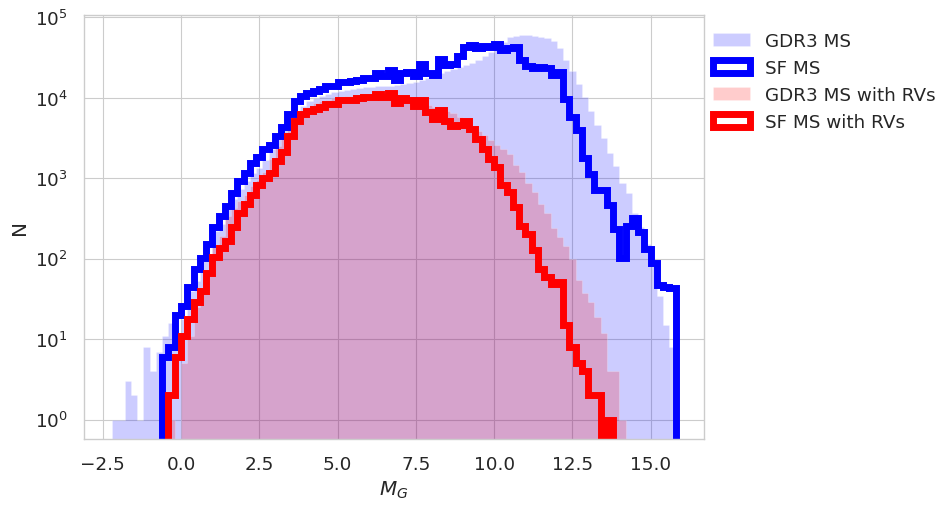

In [20]:
dMGbins         = 0.2
MGbins          = np.arange(gdr3MS.MG.min()-gdr3MS.MG.min()%dMGbins,gdr3MS.MG.max()-gdr3MS.MG.max()%dMGbins+dMGbins,dMGbins)
plt.hist(gdr3MS.MG,bins=MGbins,histtype='stepfilled',log=True,label='GDR3 MS',color='blue',alpha=0.2);
plt.hist(gogMS.MG,bins=MGbins,histtype='step',log=True,label='SF MS',color='blue',linewidth=5);
plt.hist(gdr3RVMS.MG,bins=MGbins,histtype='stepfilled',log=True,label='GDR3 MS with RVs',color='red',alpha=0.2);
plt.hist(gogRVMS.MG,bins=MGbins,histtype='step',log=True,label='SF MS with RVs',color='red',linewidth=5);
plt.xlabel(r'$M_G$');
plt.ylabel(r'N');
plt.legend(bbox_to_anchor=(0.0, 0.0, 1.4, 1.));
plt.savefig('gogVsGaiaMSPhotometricDistributions.png',bbox_inches='tight')

# Final synthetic field construction

## The random coordinate generator for uniform spherical distributions

In [21]:
# Here we define a function that generate n random uniformly distributed point within a sphere (or disc) of radius R
def randomUniformSpherical(n,Rmax,columns):
# In case the user desire a 3-d distribution
    if len(columns) == 3:
        R     = Rmax*(np.random.uniform(0,1,n))**(1/3)
        theta = np.arccos(1-2*np.random.uniform(0,1,n))
        phi   = np.random.uniform(0,2*np.pi,n)
        data  = pd.DataFrame({columns[0]:R*np.cos(phi)*np.sin(theta),columns[1]:R*np.sin(phi)*np.sin(theta),columns[2]:R*np.cos(theta)})

# In case the user desire a 2-d distribution
    if len(columns) == 2:
        R     = Rmax*(np.random.uniform(0,1,n))**(1/2)
        phi   = np.random.uniform(0,2*np.pi,n)
        data  = pd.DataFrame({columns[0]:R*np.cos(phi),columns[1]:R*np.sin(phi)})
    return data

## The random star generator

In [22]:
# Here we define a function designed to generate a set of stars that have positions, propper motions and photometry similar to GOG sample
def randomStarGenerator(data,data1,data2,r,kinematicrR,nProcessors,MGLims,kinematicColumns):
    stars     = pd.DataFrame()
    Ndiff     = data2.shape[0]-data1.shape[0]
    data      = data[data.pmra**2+data.pmdec**2 <= 250**2] 
    
        
    MGminForPhoto     = np.max([MGLims[0],MS_MG_to_BR_interp.x.min()])
    MGmaxForPhoto     = np.min([MGLims[1],MS_MG_to_BR_interp.x.max()])
    
    if (np.max([data1.shape[0],data2.shape[0]]) < 100) & (MGLims[0] <= MGmaxForPhoto) & (MGminForPhoto <= MGLims[1]):
        dataForPhoto      = pd.DataFrame({'MG':np.random.uniform(MGminForPhoto,
                                                                 MGmaxForPhoto,
                                                                 500),
                                          'BR':np.linspace(MS_MG_to_BR_interp(MGmaxForPhoto),
                                                         MS_MG_to_BR_interp(MGminForPhoto),
                                                         500)})
    
    elif data1.shape[0] < data2.shape[0]:
        dataForPhoto      = pd.DataFrame({'MG':data2.MG,'BR':data2.BR})
    else:
        dataForPhoto      = pd.DataFrame({'MG':data1.MG,'BR':data1.BR})
    
    randomToMG = interpolate.interp1d(np.arange(dataForPhoto.shape[0]) / (dataForPhoto.shape[0] - 1),np.sort(dataForPhoto.MG))
    randomToBR = interpolate.interp1d(np.arange(dataForPhoto.shape[0]) / (dataForPhoto.shape[0] - 1),np.sort(dataForPhoto.BR))
    FakePhoto  = pd.DataFrame({'BR':randomToBR(np.random.random(Ndiff)),'MG':randomToMG(np.random.random(Ndiff))})
    
    def NeumanPositions(n,kinematicColumns):
        subStars  = pd.DataFrame()
        condition = True  
        
        if len(kinematicColumns) == 3:
            kinematicLimit = 100
            fractionLimit  = 1e-4
        else:
            kinematicLimit = 170
            fractionLimit  = 1e-3
        while condition:
            star           = pd.concat([randomUniformSpherical(1,200,['X','Y','Z']),randomUniformSpherical(1,kinematicLimit,kinematicColumns)],axis=1)
            randomFraction = np.random.uniform(0,fractionLimit)
            
            kinematicSum = 0
            for column in kinematicColumns:
                kinematicSum += (data[column]-star[column][0])**2
            
            trueFraction      = data[((data.X-star.X[0])**2 + (data.Y-star.Y[0])**2 + (data.Z-star.Z[0])**2 <= r**2) &
                                  (kinematicSum <= kinematicrR**2)].shape[0]/data.shape[0]
            
            condition1        = (trueFraction == 0)
            condition2        = (randomFraction > trueFraction)
            condition         = condition1 | condition2
        subStars = pd.concat([subStars,star],axis=0).reset_index(drop=True)
        return subStars
    
    listStars = Parallel(n_jobs=nProcessors)(delayed(NeumanPositions)(j,kinematicColumns) for j in np.arange(0,Ndiff,1))
    for i in np.arange(0,len(listStars),1):
        stars = pd.concat([stars,listStars[i]],axis=0).reset_index(drop=True)
    stars = pd.concat([stars,FakePhoto],axis=1)
    
    return stars,listStars

In [23]:
common_path = 'builded_or_modified_cat/'

# Building of the $6\mathcal{D}$ synthetic field

In [24]:
# We define the basice objects needed to build the final synthetic fields
dMGbins         = 0.2
MGbins          = np.arange(gdr3.MG.min()-gdr3.MG.min()%dMGbins+dMGbins,gdr3.MG.max()-gdr3.MG.max()%dMGbins+dMGbins,dMGbins)
gogRVFinalField = pd.DataFrame(columns = gogRVMS.columns)
minID           = gogMS.source_id.max()

# We go MG bin by bin, building the MS field in such a way it reproduce the Gaia DR3 LF
for mg in np.arange(0,len(MGbins)-1,1):
    MGmin       = round(MGbins[mg],3)
    MGmax       = round(MGbins[mg+1],3)
    print(f'-------------{MGmin}-----------------------')
    
    # We separate in each bin stars with RVs from stars without RVs
    gogMG       = gogMS[(gogMS.MG >= MGmin) &
                        (gogMS.MG < MGmax) &
                        (gogMS.radial_velocity_error.isnull().values == True)]
    
    gogRVMG     = gogRVMS[(gogRVMS.MG >= MGmin) &
                          (gogRVMS.MG < MGmax)]
    
    gdr3RVMG    = gdr3RVMS[(gdr3RVMS.MG >= MGmin) &
                             (gdr3RVMS.MG < MGmax)]
    
    # We compute the difference between the number of stars with RVs in real and fake data
    NdiffRV     = gdr3RVMG.shape[0]-gogRVMG.shape[0]
    
    # If there are more stars in GOG we keep the n stars with better probabilities where n is the number of stars in Gaia in this bin
    if NdiffRV <= 0:
        gogRVchosen = gogRVMG.sort_values('p').tail(gdr3RVMG.shape[0])
        
    # If not, we add stars with fake RVs with the better probabilities
    else:
        gogRVchosen = pd.concat([gogRVMG,gogMG.sort_values('error_over_parallax').tail(NdiffRV)],axis=0).reset_index(drop=True)
        
        if (gogRVchosen.shape[0] < gdr3RVMG.shape[0]):
            
            newStars,listStars = randomStarGenerator(gogRVMS,gogRVchosen,gdr3RVMG,35,10,18,[MGmin,MGmax],['U','V','W'])
            newStars           = pd.concat([pd.DataFrame({'source_id':np.arange(minID+1,newStars.shape[0]+minID+1,1)}),newStars],axis=1)    
            minID              = newStars.source_id.max()
    
            gogRVchosen        = pd.concat([gogRVchosen,newStars],axis=0).reset_index(drop=True)

    gogRVFinalField = pd.concat([gogRVFinalField,gogRVchosen],axis=0).reset_index(drop=True)
    
    print(gogRVFinalField[(gogRVFinalField.set_index(gogRVFinalField.source_id).index.duplicated()) &
                          (gogRVFinalField.source_id>0)].MG.min())
    
    # This is GOG final field with RVs
    gogRVFinalField.to_csv(common_path+'gogRVFinalField.csv',index=False)

--------------4.0-----------------------
nan
--------------3.8-----------------------
nan
--------------3.6-----------------------
nan
--------------3.4-----------------------
nan
--------------3.2-----------------------
nan
--------------3.0-----------------------
nan
--------------2.8-----------------------
nan
--------------2.6-----------------------
nan
--------------2.4-----------------------
nan
--------------2.2-----------------------
nan
--------------2.0-----------------------
nan
--------------1.8-----------------------
nan
--------------1.6-----------------------
nan
--------------1.4-----------------------
nan
--------------1.2-----------------------
nan
--------------1.0-----------------------
nan
--------------0.8-----------------------
nan
--------------0.6-----------------------
nan
--------------0.4-----------------------
nan
--------------0.2-----------------------
nan
-------------0.0-----------------------
nan
-------------0.2-----------------------
nan
------------

KeyboardInterrupt: 

# Building of the $5\mathcal{D}$ synthetic field

In [ ]:
# We define the basice objects needed to build the final synthetic fields
gogFinalField   = pd.DataFrame(columns = gogMS.columns)
minID           = np.max([gogMS.source_id.max(),gogRVFinalField.source_id.max()])

# We go MG bin by bin, building the MS field in such a way it reproduce the Gaia DR3 LF
for mg in np.arange(0,len(MGbins)-1,1):
    MGmin       = round(MGbins[mg],3)
    MGmax       = round(MGbins[mg+1],3)
    print(f'-------------{MGmin}-----------------------')
    
    # We separate in each bin stars with RVs from stars without RVs
    gogMG       = gogMS[(gogMS.MG >= MGmin) &
                        (gogMS.MG < MGmax) &
                        (gogMS.radial_velocity_error.isnull().values == True)]
    
    gdr3MG      = gdr3MS[(gdr3MS.MG >= MGmin) &
                         (gdr3MS.MG < MGmax)]
    
    gogRVchosen = gogRVFinalField[(gogRVFinalField.MG >= MGmin) &
                                  (gogRVFinalField.MG < MGmax)]
            
    # We want to keep the stars selected previously in the field for propper motion space, so if there are more stars in GOG 
    # than in Gaia in this bin we join it with the best n stars in this bin that doesn´t have RVs where n is the number of 
    # stars in Gaia in this bin (here we use the fractional parallax error).
    NdiffRV = gdr3MG.shape[0]-gogRVchosen.shape[0]  
    
    # Objects in gogMG that are not in gogRVchosen
    NgogNotInChosen  = np.max([0,gogMG.shape[0]-NdiffRV])
    gogMGnotInChosen = gogMG.sort_values('error_over_parallax').head(NgogNotInChosen)
        
    gogChosen = pd.concat([gogRVchosen,gogMGnotInChosen.sort_values('error_over_parallax').tail(NdiffRV)],axis=0).reset_index(drop=True)
    
    Ndiff = gdr3MG.shape[0]-gogChosen.shape[0]  
    
    if Ndiff > 0:
        newStars,listStars = randomStarGenerator(gogMS,gogChosen,gdr3MG,35,20,18,[MGmin,MGmax],['pmra','pmdec'])
        newStars           = pd.concat([pd.DataFrame({'source_id':np.arange(minID+1,newStars.shape[0]+minID+1,1)}),newStars],axis=1)
        minID              = newStars.source_id.max()
        
        gogChosen = pd.concat([gogChosen,newStars],axis=0).reset_index(drop=True)
        
    # We add the information to both fields respectively
    gogFinalField = pd.concat([gogFinalField,gogChosen],axis=0).reset_index(drop=True)
    
    print(gogFinalField[(gogFinalField.set_index(gogFinalField.source_id).index.duplicated()) & (gogFinalField.source_id>0)].MG.min())
    
    # This is GOG final field with RVs
    gogFinalField.to_csv(common_path+'gogFinalField.csv',index=False)

In [ ]:
plt.hist(gogRVFinalField.Z,bins=np.arange(-200,200,5),histtype='step',density=True);
plt.hist(gdr3RVMS.Z,bins=np.arange(-200,200,5),histtype='step',density=True);
plt.hist(gogRVMS.Z,bins=np.arange(-200,200,5),histtype='step',density=True);

In [ ]:
plt.hist(gogRVFinalField.Z,bins=np.arange(-200,200,5),histtype='step',density=True);
plt.hist(gdr3RVMS.Z,bins=np.arange(-200,200,5),histtype='step',density=True);
plt.hist(gogRVMS.Z,bins=np.arange(-200,200,5),histtype='step',density=True);

In [ ]:
dMGbins         = 0.2
MGbins          = np.arange(gdr3MS.MG.min()-gdr3MS.MG.min()%dMGbins,gdr3MS.MG.max()-gdr3MS.MG.max()%dMGbins+dMGbins,dMGbins)
plt.hist(gdr3MS.MG,bins=MGbins,histtype='stepfilled',log=True,label='GDR3 MS',color='blue',alpha=0.2);
plt.hist(gogFinalField.MG,bins=MGbins,histtype='step',log=True,label='SF MS',color='blue',linewidth=5);
plt.hist(gdr3RVMS.MG,bins=MGbins,histtype='stepfilled',log=True,label='GDR3 MS with RVs',color='red',alpha=0.2);
plt.hist(gogRVFinalField.MG,bins=MGbins,histtype='step',log=True,label='SF MS with RVs',color='red',linewidth=5);
plt.xlabel(r'$M_G$')
plt.ylabel(r'N')
plt.legend(bbox_to_anchor=(0.0, 0.0, 1.4, 1.))

# Fields and data saving

In [ ]:
# This is GOG final field with RVs
gogRVFinalField.to_csv(common_path+'gogRVFinalField.csv',index=False)

# This is GOG final field for propper motion analysis 
gogFinalField.to_csv(common_path+'gogFinalField.csv',index=False)

In [ ]:
# This all of GOG cleaned
gogClean.to_csv(common_path+'gog_XYZUVW.csv',index=False)

# This is all of GDR3 cleaned
gdr3Clean.to_csv(common_path+'gdr3_XYZUVW.csv',index=False)

# This is all of GDR# MS and PMS cleaned
gdr3MSPMS.to_csv(common_path+'gdr3MSPMS.csv',index=False)

# This is all of GDR3 MS cleaned
gdr3MS.to_csv(common_path+'gdr3MS.csv',index=False)

# This is all of GDR3 MS and PMS with RVs cleaned
gdr3RVMSPMS.to_csv(common_path+'gdr3RVMSPMS.csv',index=False)

# This is all of GDR3 MS with RVs cleaned
gdr3RVMS.to_csv(common_path+'gdr3RVMS.csv',index=False)

# MG error data builded based on GDR3 MG error
MGerrInterp.to_csv(common_path+'MGerrInterp.csv',index=False)